# Homework — GEIM and Data Assimilation (v2)

## Learning objectives

This homework explores the **Generalized Empirical Interpolation Method (GEIM)** for:
- Building sensor dictionaries with different linear functionals
- Greedy basis construction with simultaneous sensor selection
- Data assimilation from sparse measurements
- Stability analysis (Lebesgue constants, conditioning)
- Robustness to noise via overdetermination and regularization

**Key concepts:** Linear functionals, greedy algorithms, interpolation theory, least squares, Tikhonov regularization.

**Tools:** NumPy for numerics, Matplotlib for visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
np.random.seed(7)

## 1. Problem setup

In [2]:
Nq = 800
x = np.linspace(0.0, 1.0, Nq)
mu_box = np.array([[0.0,2.0],[0.0,2.0],[0.2,0.8]])
def s_fun(x, mu):
    mu1,mu2,mu3 = mu
    return (1+mu1)*np.sin((1+mu2)*np.pi*x) + np.exp(-20.0*(x-mu3)**2)
def sample_mu(n):
    u = np.random.rand(n,3)
    return mu_box[:,0] + u*(mu_box[:,1]-mu_box[:,0])
n_train, n_test = 300, 150
mu_train, mu_test = sample_mu(n_train), sample_mu(n_test)
assert mu_train.shape==(n_train,3) and mu_test.shape==(n_test,3)

## 2. Sensor dictionary $A$
TODO: implement Dirac-like probes (subsampled), box averages, Gaussian sensors; normalize rows.

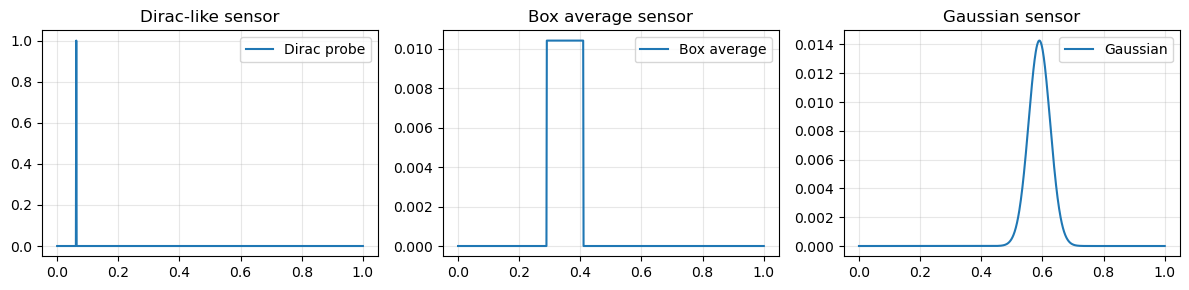

In [3]:
def make_dictionary(x, stride=10, n_boxes=16, box_width=0.06, n_gauss=16, sigma=0.035):
    # --- TODO ---
    # raise NotImplementedError('make_dictionary')
    A_list = []
    # Dirac sensors
    idx = np.arange(0, len(x), stride)
    for i in idx:
        row = np.zeros_like(x)
        row[i] = 1.0
        A_list.append(row)

    # Box-average sensors
    centers = np.linspace(0.05, 0.95, n_boxes)
    for c in centers:
        mask = np.abs(x - c) < box_width
        row = np.zeros_like(x)
        row[mask] = 1.0
        if row.sum() > 0:
            row /= row.sum()
            A_list.append(row)

    # Gaussian sensors
    gauss_centers = np.linspace(0.05, 0.95, n_gauss)
    for c in gauss_centers:
        row = np.exp(-(x - c)**2 / (2*sigma*sigma))
        row /= np.sum(np.abs(row))
        A_list.append(row)

    A = np.vstack(A_list)
    return A

A = make_dictionary(x)

# Visualize sensor types
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(x, A[5], label='Dirac probe')
axes[0].set_title('Dirac-like sensor')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(x, A[85], label='Box average')
axes[1].set_title('Box average sensor')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(x, A[105], label='Gaussian')
axes[2].set_title('Gaussian sensor')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Utility: forward substitution (unit diagonal)

In [4]:
def forward_solve(L, b):
    # --- TODO ---
    # raise NotImplementedError('forward_solve')
    L = np.asarray(L)
    b = np.asarray(b)

    M = L.shape[0]

    if b.ndim == 1:
        gamma = np.zeros(M)
        for i in range(M):
            gamma[i] = b[i] - np.dot(L[i,:i], gamma[:i])
        return gamma

    else:
        k = b.shape[1]
        gamma = np.zeros((M,k))
        for i in range(M):
            gamma[i] = b[i] - L[i,:i] @ gamma[:i]
        return gamma

## 3. GEIM offline (greedy)

**GEIM idea.** Build basis functions $\{\rho_j\}$ and a set of **sensors** $\{L_i\}$ such that
$$ L_i\big(I_M g\big) = L_i(g), \quad i=1,\dots,M, $$
with $I_M g(x) = \sum_{j=1}^M \gamma_j(\mu)\,\rho_j(x)$ and the interpolation matrix $B_M = [L_i(\rho_j)]$ **lower‑triangular with ones on the diagonal** (by normalization).

**Task B.** Implement the GEIM greedy algorithm:
1. Precompute training snapshots `S` on the grid for `mu_train`.
2. **Select** $\mu_1$ maximizing $\|g(\cdot;\mu)\|_\infty$; set $\xi_1=g(\cdot;\mu_1)$. **Choose** $L_1$ maximizing $|L(\xi_1)|$ over the dictionary and set $\rho_1=\xi_1 / L_1(\xi_1)$.
3. For $m=1,\dots,M-1$:
   - Pick $\mu_{m+1}$ maximizing the current interpolation error $\|g-I_m g\|_\infty$ over the training set.
   - Compute the residual $r_{m+1}=\xi_{m+1}-I_m\xi_{m+1}$.
   - **Choose** $L_{m+1}$ in the dictionary (not yet used) maximizing $|L(r_{m+1})|$.
   - Set $\rho_{m+1}=r_{m+1}/L_{m+1}(r_{m+1})$.

Store: `Q` ($N_q\times M$), sensor indices list `J` (rows of `A`), selected training parameters, training errors, and (optionally) a discrete Lebesgue constant.

*Hints.*
- To reconstruct a snapshot with current $(Q_m, J_m)$: build $B_m=A[J_m,:]@Q_m$, measure $g_I=A[J_m,:]@g$, solve $\gamma=\text{forward\_solve}(B_m, g_I)$, then `approx = Q_m @ gamma`.
- With the normalization above, `B_m` is lower‑triangular with a unit diagonal by construction.


In [5]:
@dataclass
class GEIMModel:
    Q: np.ndarray
    J: list
    mu_sel: list
    train_err: list
    lebesgue: list

def geim_offline(s_fun, x, mu_train, A, M_max=16, tol=1e-6):
    """
    GEIM greedy offline algorithm.
    Returns GEIMModel with basis Q, sensor indices J, and diagnostics.
    """
    Nq = len(x)
    n_train = len(mu_train)
    Ns = A.shape[0]
    
    # Precompute all training snapshots
    print("Precomputing training snapshots...")
    S = np.zeros((Nq, n_train))
    for i, mu in enumerate(mu_train):
        S[:, i] = s_fun(x, mu)
    
    Q_list = []
    J_list = []
    mu_sel = []
    train_err = []
    lebesgue = []
    
    # Step 1: Select first parameter with maximum norm
    norms = np.max(np.abs(S), axis=0)
    idx1 = np.argmax(norms)
    mu1 = mu_train[idx1]
    xi1 = S[:, idx1]
    
    # Select first sensor maximizing |L(xi1)|
    sensor_vals = np.abs(A @ xi1)
    j1 = np.argmax(sensor_vals)
    
    # First basis function (normalized)
    rho1 = xi1 / (A[j1, :] @ xi1)
    
    Q_list.append(rho1)
    J_list.append(j1)
    mu_sel.append(mu1)
    
    print(f"GEIM m=1: selected sensor {j1}, ||xi||_inf={norms[idx1]:.4e}")
    
    used_sensors = {j1}
    
    # Greedy loop
    for m in range(1, M_max):
        Q_m = np.column_stack(Q_list)
        J_m = J_list
        
        # Build B_m = A[J_m, :] @ Q_m
        B_m = A[J_m, :] @ Q_m
        
        # Compute interpolation error for all training samples
        errors = np.zeros(n_train)
        for i in range(n_train):
            g = S[:, i]
            y = A[J_m, :] @ g
            gamma = forward_solve(B_m, y)
            g_interp = Q_m @ gamma
            errors[i] = np.max(np.abs(g - g_interp))
        
        # Select parameter with maximum error
        idx_max = np.argmax(errors)
        max_err = errors[idx_max]
        train_err.append(max_err)
        
        if max_err < tol:
            print(f"GEIM converged at m={m} with error {max_err:.6e}")
            break
        
        mu_next = mu_train[idx_max]
        xi_next = S[:, idx_max]
        
        # Compute residual
        y_next = A[J_m, :] @ xi_next
        gamma_next = forward_solve(B_m, y_next)
        r_next = xi_next - Q_m @ gamma_next
        
        # Select next sensor (not yet used) maximizing |L(r)|
        sensor_vals = np.abs(A @ r_next)
        sensor_vals[list(used_sensors)] = -1  # Exclude used sensors
        j_next = np.argmax(sensor_vals)
        
        # New basis function (normalized)
        rho_next = r_next / (A[j_next, :] @ r_next)
        
        Q_list.append(rho_next)
        J_list.append(j_next)
        mu_sel.append(mu_next)
        used_sensors.add(j_next)
        
        # Compute discrete Lebesgue constant
        B_new = A[J_list, :] @ np.column_stack(Q_list)
        B_inv = np.linalg.inv(B_new)
        interp_matrix = np.column_stack(Q_list) @ B_inv
        Lambda_m = np.max(np.sum(np.abs(interp_matrix), axis=1))
        lebesgue.append(Lambda_m)
        
        if (m+1) % 5 == 0 or m == M_max-1:
            print(f"GEIM m={m+1}: error={max_err:.4e}, Lambda={Lambda_m:.2f}, sensor={j_next}")
    
    Q = np.column_stack(Q_list)
    return GEIMModel(Q=Q, J=J_list, mu_sel=mu_sel, train_err=train_err, lebesgue=lebesgue)

# Run GEIM offline
model = geim_offline(s_fun, x, mu_train, A, M_max=30, tol=1e-4)

Precomputing training snapshots...
GEIM m=1: selected sensor 36, ||xi||_inf=3.9936e+00
GEIM m=5: error=7.0136e-01, Lambda=1.73, sensor=53
GEIM m=10: error=8.0774e-03, Lambda=4.23, sensor=46
GEIM converged at m=13 with error 5.485758e-05


## 4. GEIM online (assimilation)


**Task C.** Given `model` and a set of sensor measurements `y` at the selected sensors (rows `J`), reconstruct the field $g_M$ by solving
$$ B_M\,\gamma = y, \quad B_M = A[J,:]@Q, \quad g_M = Q\,\gamma. $$
Return `(gM, gamma)`.

In [6]:
def geim_online(model, A, y):
    # --- TODO ---
    # raise NotImplementedError('geim_online')
    Q = model.Q
    J = model.J

    B = A[J,:] @ Q
    gamma = forward_solve(B, y)
    gM = Q @ gamma
    return gM, gamma

## 5. Sanity checks (after offline/online)


Check triangularity/unit diagonal of B=A[J,:]@Q and interpolation at selected sensors. 

After you implement `make_dictionary` and `geim_offline`, build a model with `M_max≈20` and verify:
- `B = A[J,:] @ Q` is lower‑triangular with (approximately) unit diagonal.
- Interpolation holds at selected sensors on the training snapshots: `A[J,:] @ (Q @ gamma) == A[J,:] @ g` for all training `g` when `gamma` solves `B gamma = A[J,:] @ g`.

In [7]:
A = make_dictionary(x)
model = geim_offline(s_fun, x, mu_train, A, M_max=16, tol=1e-8)
B = A[model.J,:] @ model.Q
assert np.allclose(np.tril(B), B)
assert np.allclose(np.diag(B), 1.0, atol=1e-12)
S_train = np.stack([s_fun(x, mu) for mu in mu_train], axis=1)
rhs = A[model.J,:] @ S_train
gamma = forward_solve(B, rhs)
interp = model.Q @ gamma
assert np.allclose(A[model.J,:] @ interp, rhs, atol=1e-10)

Precomputing training snapshots...
GEIM m=1: selected sensor 36, ||xi||_inf=3.9936e+00
GEIM m=5: error=7.0136e-01, Lambda=1.73, sensor=53
GEIM m=10: error=8.0774e-03, Lambda=4.23, sensor=46
GEIM m=15: error=9.5890e-06, Lambda=10.49, sensor=12
GEIM m=16: error=3.5849e-06, Lambda=13.78, sensor=71


## 6. Data assimilation: noise-free

**Task D.** Pick a fresh parameter `mu0`, generate measurements `y = A[J,:] @ s_fun(x, mu0)`, reconstruct with `geim_online`, and report the sup‑norm error `||truth - gM||_∞`. Plot the truth vs reconstruction.


sup error (noise-free): 1.553618139416013e-07


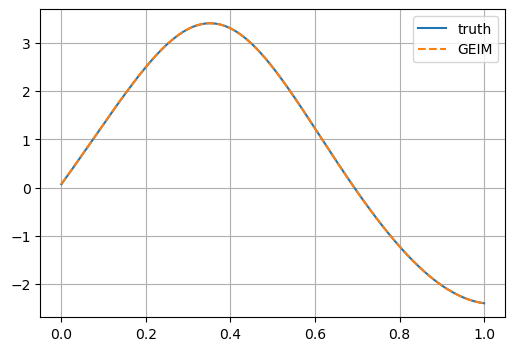

In [8]:
mu0 = sample_mu(1)[0]
truth = s_fun(x, mu0)
y = (A[model.J,:] @ truth)
gM, _ = geim_online(model, A, y)
print('sup error (noise-free):', float(np.max(np.abs(truth-gM))))
plt.figure(figsize=(6,4))
plt.plot(x, truth, label='truth')
plt.plot(x, gM, '--', label='GEIM')
plt.legend()
plt.grid(True)
plt.show()

## 7. Data assimilation: noisy and gappy (optional)

Add i.i.d. Gaussian noise of level `sigma_y` to the measurements: `y^δ = y + δ`. Run multiple trials and compute the mean and standard deviation of the reconstruction error.

**Task E (deterministic GEIM).** Repeat Task D with noisy measurements (same $M$). Study sensitivity as a function of (i) $M$, and (ii) the conditioning of $B_M$.

**Task F (gappy‑GEIM: overdetermined).** Use **more sensors than basis functions** (|I| > M). Solve the least‑squares problem
$$\min_\gamma \; \|A[I,:]Q\,\gamma - y^\delta\|_2^2 + \tau\,\|\gamma\|_2^2,$$
for some Tikhonov parameter $\tau \ge 0$. Compare errors vs the square case. *Hint:* use the normal equations or `np.linalg.lstsq` when $\tau=0$; with Tikhonov, solve $(B^TB+\tau I)\gamma=B^Ty$ with $B=A[I,:]Q$.

In [9]:
def geim_online_gappy(Q, A, I_rows, y, tau=0.0):
    # --- OPTIONAL TODO ---
    raise NotImplementedError('geim_online_gappy')

## 8. Diagnostics
TODO: test-set sup error vs M; discrete Lebesgue constants; cond(B_m). **Task G.**
1) **Test‑set error curve**: for each $m=1,\dots,M$, reconstruct all test functions from measurements at the first $m$ sensors, and report $\max_{x,\mu\in\text{test}}|s-I_m s|$.
2) **Discrete Lebesgue constant** (GEIM): compute $\Lambda_m = \max_x \sum_i |(Q_m B_m^{-1})[x,i]|$ where $B_m=A[J_m,:]Q_m$. Plot growth of $\Lambda_m$.
3) **Conditioning**: plot $\kappa(B_m)$ vs $m$. Relate error sensitivity to $\Lambda_m$ and $\kappa(B_m)$.

*Hints:* These are identical to the EIM algebra with $Q$ and $B$ redefined using functionals. Compare with the lecture’s EIM error analysis and a posteriori one‑point result (you can define a “one‑functional estimator” by evaluating at the next chosen functional).

In [10]:
def test_error_curve_geim(model, x, mu_test, A):
    # --- TODO ---
    # raise NotImplementedError()
    Q = model.Q
    J = model.J

    M = Q.shape[1]
    n_test = len(mu_test)
    Nq = len(x)

    S_test = np.zeros((Nq, n_test))
    for i, mu in enumerate(mu_test):
        S_test[:, i] = s_fun(x, mu)

    err_curve = np.zeros(M)

    for m in range(1, M + 1):
        Q_m = Q[:, :m]
        J_m = J[:m]

        B_m = A[J_m, :] @ Q_m

        rhs = A[J_m, :] @ S_test

        gamma = forward_solve(B_m, rhs)

        S_rec = Q_m @ gamma

        sup_errs = np.max(np.abs(S_test - S_rec), axis=0)
        err_curve[m - 1] = float(np.max(sup_errs))

    return err_curve


def discrete_lebesgue_constants_geim(Q, J, A):
    # --- TODO ---
    # raise NotImplementedError()
    M = Q.shape[1]
    lebesgue = np.zeros(M)

    for m in range(1, M + 1):
        Q_m = Q[:, :m]
        J_m = J[:m]

        B_m = A[J_m, :] @ Q_m

        B_inv = np.linalg.inv(B_m)

        P_m = Q_m @ B_inv

        lebesgue[m - 1] = float(np.max(np.sum(np.abs(P_m), axis=1)))

    return lebesgue

def cond_numbers_geim(Q, J, A):
    # --- TODO ---
    # raise NotImplementedError()
    M = Q.shape[1]
    conds = np.zeros(M)

    for m in range(1, M + 1):
        Q_m = Q[:, :m]
        J_m = J[:m]
        B_m = A[J_m, :] @ Q_m  # (m x m)
        conds[m - 1] = float(np.linalg.cond(B_m))

    return conds

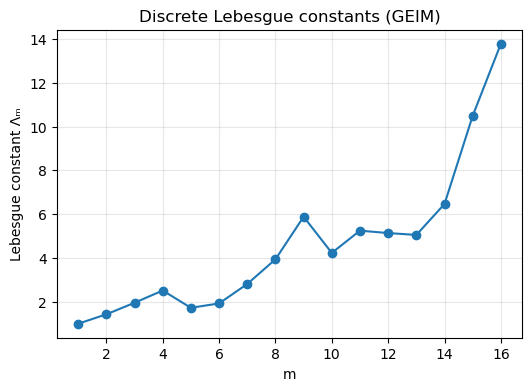

In [11]:
err_curve = test_error_curve_geim(model, x, mu_test, A)
Lambda = discrete_lebesgue_constants_geim(model.Q, model.J, A)
conds = cond_numbers_geim(model.Q, model.J, A)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(Lambda)+1), Lambda, 'o-')
plt.xlabel('m')
plt.ylabel('Lebesgue constant Λₘ')
plt.title('Discrete Lebesgue constants (GEIM)')
plt.grid(True, alpha=0.3)
plt.show()


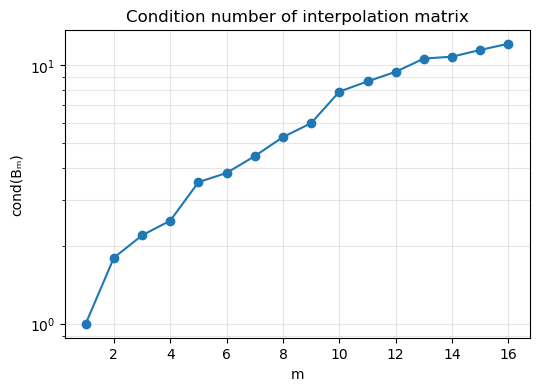

In [12]:
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(1, len(conds)+1), conds, 'o-')
plt.xlabel('m')
plt.ylabel('cond(Bₘ)')
plt.title('Condition number of interpolation matrix')
plt.grid(True, which='both', alpha=0.3)
plt.show()
